# CC Fraud Analysis

_created by Austin Poor_

Analysis of credit card fraud data. Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## EDA

Look at info about size of dataset and class balances

In [4]:
print(f"n observations => {df.shape[0]:,d}")
print(f"n features     => {df.shape[1]-1:7d}")

class_balance = df.Class.mean()
print(f"class balance  => {class_balance:7.5f}")

n observations => 284,807
n features     =>      30
class balance  => 0.00173


It looks like the classes are _super_ inbalanced

Plotting distributions for features

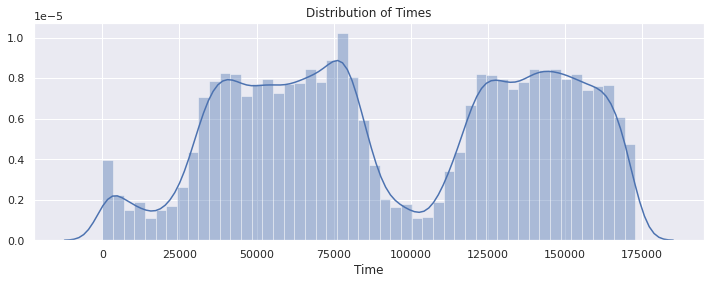

In [5]:
plt.figure(figsize=(12,4))
sns.distplot(df.Time)
plt.title("Distribution of Times");

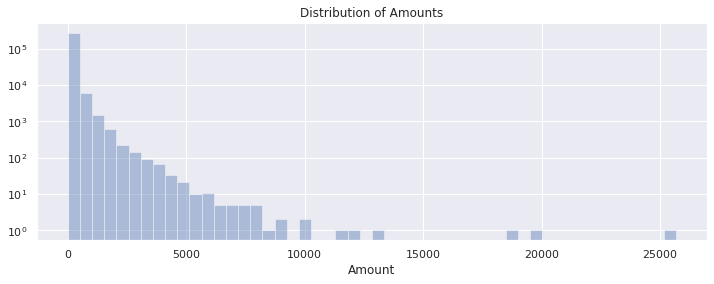

In [6]:
plt.figure(figsize=(12,4))
sns.distplot(df.Amount,kde=False)
plt.yscale('log')
plt.title("Distribution of Amounts");

Distributions for PCA transformed columns `V1`-`V28`

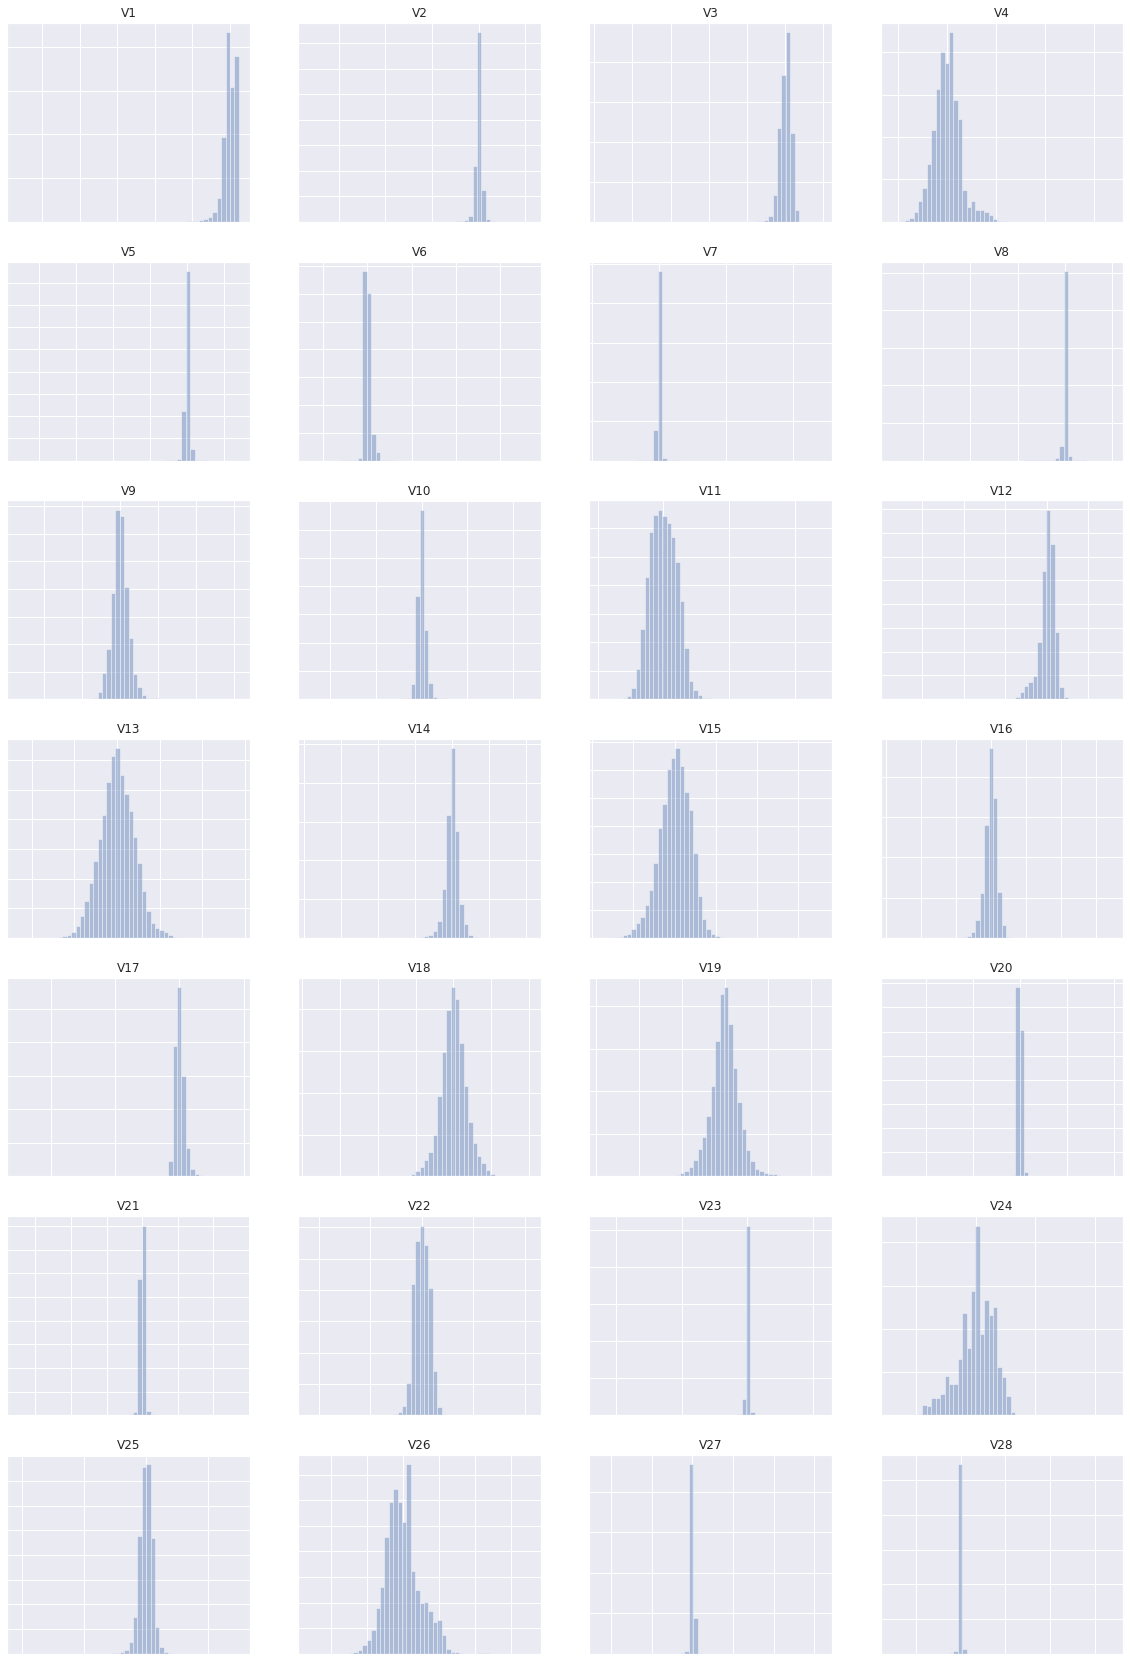

In [7]:
plt.figure(figsize=(20,30))
for i in range(1,29):
    plt.subplot(7,4,i)
    sns.distplot(df[f"V{i}"],kde=False)
    plt.title(f"V{i}")
    plt.xlabel("")
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

Examine the correlation between each feature and the target

In [8]:
df.corr()["Class"]\
    .reset_index()\
    .rename(columns={
        "index":"ColName",
        "Class":"Correlation"
    })\
    .sort_values(
        "Correlation",
        ascending=False,
        key=lambda n: abs(n)
    ).query("ColName != 'Class'")

,ColName,Correlation
17,V17,-0.326481
14,V14,-0.302544
12,V12,-0.260593
10,V10,-0.216883
16,V16,-0.196539
3,V3,-0.192961
7,V7,-0.187257
11,V11,0.154876
4,V4,0.133447
18,V18,-0.111485


---

## Building a model to make predictions

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [10]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

def cv_score(model,X,y,cv=cv):
    score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return np.mean(score), np.std(score)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df.drop(columns="Class")
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [14]:
scale = StandardScaler()

Xs_train = scale.fit_transform(X_train,y_train)
Xs_test = scale.transform(X_test)

In [15]:
logr = LogisticRegression().fit(Xs_train,y_train)
logr

LogisticRegression()

In [16]:
log_score_mean, log_score_std = cv_score(logr,Xs_train,y_train)
print(f"log  CV Score: {log_score_mean:.6f} ({log_score_std:.6f})")

log  CV Score: 0.972198 (0.014995)


In [17]:
from misc import show_confusion

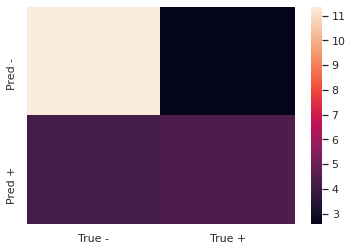

In [18]:
show_confusion(
    y_test,
    logr.predict(Xs_test),
    log_transform=True
)

In [19]:
from misc import save_model

In [20]:
save_model(
    logr,
    "logr",
    log_score_mean,
#     cutoff=1-class_balance
)

True

## Gradient Boosted Treeslog_pipeline

### XGBoost

In [21]:
from xgboost import XGBClassifier

In [22]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.33)

In [23]:
xgbc = XGBClassifier()
xgbc.fit(
    X_train,
    y_train,
    eval_set=[
        (X_val,y_val)
    ],
    verbose=False
)

xgbc_score_mean, xgbc_score_std = cv_score(xgbc,X_train,y_train)
print(f"xgbc CV Score: {xgbc_score_mean:.6f} ({xgbc_score_std:.6f})")

xgbc CV Score: 0.978714 (0.013061)


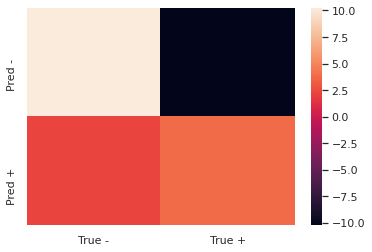

In [24]:
show_confusion(
    y_test,
    xgbc.predict(X_test),
    log_transform=True
)

In [25]:
save_model(
    xgbc,
    "xgbc",
    xgbc_score_mean,
#     cutoff=1-class_balance
)

True

### LightGBM

In [26]:
from lightgbm import LGBMClassifier

In [27]:
lgbc = LGBMClassifier(
    class_weight={
        0: 1-class_balance,
        1: class_balance
    }
)
lgbc.fit(
    X_train,
    y_train,
    eval_set=[
        (X_val,y_val)
    ],
    verbose=False
)

lgbc_score_mean,lgbc_score_std = cv_score(lgbc,X_train,y_train)
print(f"lgbc CV Score: {lgbc_score_mean:.6f} ({lgbc_score_std:.6f})")

lgbc CV Score: 0.125309 (0.054028)


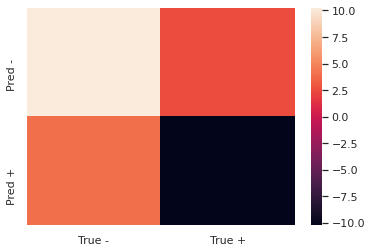

In [28]:
show_confusion(
    y_test,
    lgbc.predict(X_test),
    log_transform=True
)

In [30]:
save_model(
    lgbc,
    "lgbc",
    lgbc_score_mean,
#     cutoff=1-class_balance
)

True